In [3]:
using LinearAlgebra
using SparseArrays
using ForwardDiff;
using NLsolve;

using Plots
using LaTeXStrings

using gmsh

# Define Permeability
TODO derive from 3C92 datasheet

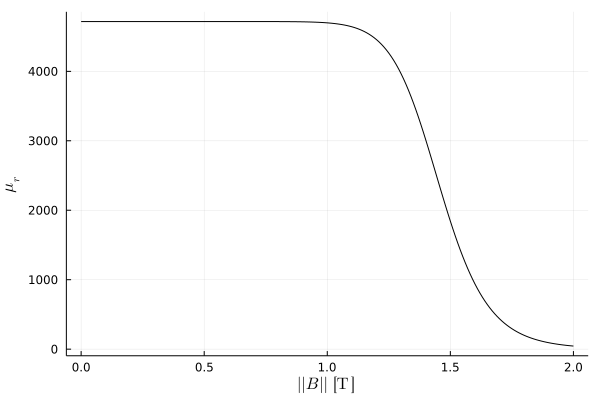

In [111]:
# Permeability function
a = 2.12e-4; 
b = 7.358;
c = 1.18e6;

mu0 = 4e-7 * pi;
fmur_core(B) = 1 / (a + (1 - a) * B^(2*b) / (B^(2*b) + c));

B = Vector(0.:0.01:2);
plot(B, fmur_core.(B), color = :black, xlabel = L"||B||\,\mathrm{[T]}", ylabel = L"\mu_r", legend = false)

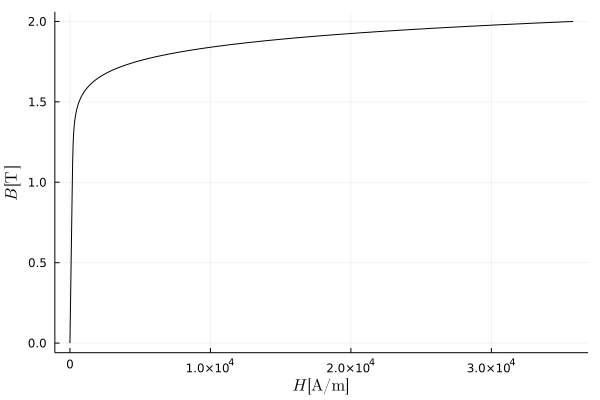

In [112]:
plot(B ./ (mu0 * fmur_core.(B)), B, color = :black, xlabel = L"H\,\mathrm{[A/m]}", ylabel = L"B\,\mathrm{[T]}", legend = false)

# Define Geometry

In [4]:
gmsh.finalize();
gmsh.initialize();

In [5]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [6]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Auxiliary Functions

In [7]:
function get_idx(node_id, nids)
    return findall(x -> x == node_id, nids)[1];
end

function bnd_dirichlet(idx, a, A, f)
    A[idx,:]   = zeros(length(f));
    A[idx,idx] = 1;
    f[idx] = a;
    
    return A, f;
end

bnd_dirichlet (generic function with 1 method)

# Linear Elements

In [94]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

In [95]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), length(x), length(x)); 
    f = zeros(length(x)); 
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        floc = h/2 * [1; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] / h * [1 -1; -1 1];
        
        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
    A, f = bnd_dirichlet(get_idx(8, nids), 0, A, f);    # Boundary at x = 1
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [96]:
A0, f0 = assemble_matrices(zeros(size(x)))
ulin = A0 \ f0;

results = nlsolve(res!, ulin, autodiff = :forward, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.843447e+02              NaN
     1     1.265401e+02     9.955841e-03
     2     3.376612e+01     7.741072e-03
     3     4.791393e+00     3.956356e-03
     4     1.356781e-01     7.660966e-04
     5     1.160822e-04     2.298065e-05
     6     5.962420e-09     1.969395e-08


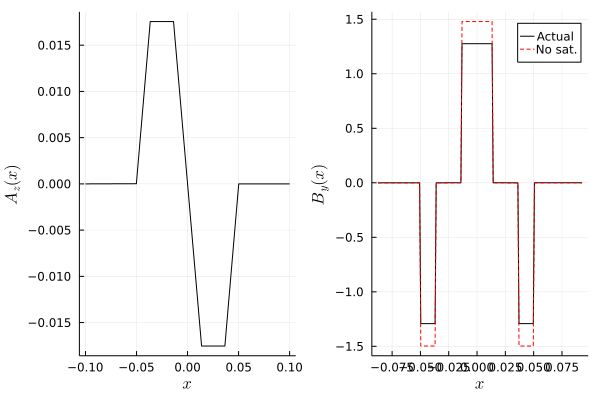

In [98]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, label = "Actual");
p2 = plot!(xmid, -diff(ulin) ./ diff(x), color = :red, style = :dash, label = "No sat.")

plot(p1, p2)

# Linear Elements & Eddy Currents

In [161]:
#..Set the source function 
J = 5e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 0.2e6;
omega = 2*pi*f;

In [162]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
points = collect( [x[i], x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1] for i in 1:length(x)-1); 

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), length(x), length(x)); 
    f = zeros(length(x)); 
    
    B = abs.(diff(u) ./ diff(x));
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xr = points[i,:][1]
        h = xr - xl;

        floc = h/2 * [1; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] / h * [1 -1; -1 1] + 1im * omega * fsigma_elem[i] * [1/3 1/6; 1/6 1/3] * h;
        
        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A, f = bnd_dirichlet(get_idx(1, nids), 0, A, f);    # Boundary at x = 0
    A, f = bnd_dirichlet(get_idx(8, nids), 0, A, f);    # Boundary at x = 1
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [163]:
#ForwardDiff.can_dual(::Type{ComplexF64}) = true

A0, f0 = assemble_matrices(zeros(Complex{Float64}, size(x)))
ulin = A0 \ f0;

results = nlsolve(res!, ulin, autodiff = :finite, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     8.420007e+05              NaN
     1     2.219133e+05     2.014675e-03
     2     7.452390e+04     1.137191e-03
     3     2.590065e+04     3.457619e-04
     4     9.080821e+03     8.004204e-04
     5     3.159834e+03     6.320345e-04
     6     1.064921e+03     5.933968e-04
     7     3.303652e+02     5.159256e-04
     8     1.150919e+02     3.763719e-04
     9     1.003527e+02     2.741664e-04
    10     8.520957e+01     3.394054e-04
    11     6.734306e+01     2.735740e-04
    12     5.473478e+01     1.953381e-04
    13     4.521105e+01     1.508445e-04
    14     3.773409e+01     1.207746e-04
    15     3.171955e+01     9.868257e-05
    16     2.680089e+01     8.167453e-05
    17     2.273131e+01     6.819596e-05
    18     1.933555e+01     5.730515e-05
    19     1.648405e+01     4.838329e-05
    20     1.407800e+01     4.099983e-05
    21     1.204017e+01     3.484231e-05
    22     1.03091

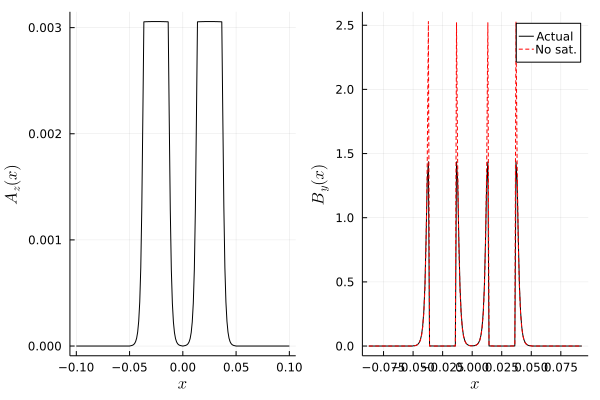

In [164]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, label = "Actual");
p2 = plot!(xmid, norm.(diff(ulin) ./ diff(x)), color = :red, style = :dash, label = "No sat.")

plot(p1, p2)

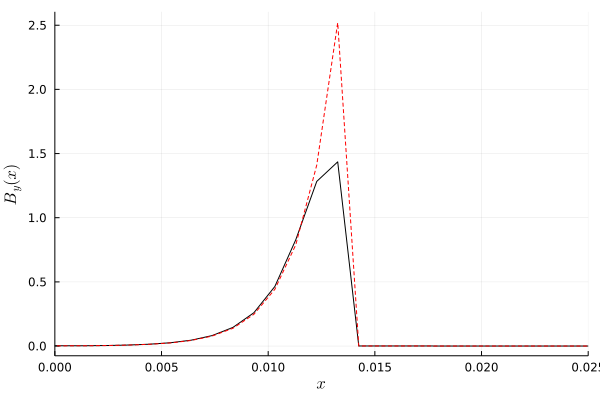

In [165]:
p2 = plot(xmid, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false)
p2 = plot!(xmid, norm.(diff(ulin) ./ diff(x)), color = :red, style = :dash, label = "No sat.")
xlims!((0, 0.025))

# Quadratic Elements & Eddy Currents

In [ ]:
#..Set the source function 
J = 5e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

# Permittivity and reluctivity
mu0 = 4e-7 * pi;
fmu(group_id, B) = mu0 + (fmur_core(B) - 1) * mu0 * (group_id == 2);
fnu(group_id, B) = 1 / fmu(group_id, B);

sigma_core = 1e2;
fsigma(group_id) = sigma_core * (group_id == 2);
fsigma_elem = map(fsigma, e_group)

f     = 0.2e6;
omega = 2*pi*f;

In [166]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

function assemble_matrices(u) 
    #..Initialize global matrix and right-hand side value 
    A = zeros(eltype(u), Na, Na); 
    B = zeros(eltype(u), Na);
    f = zeros(Na);
    
    # Calculate magnetic flux density
    Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        ul, um, ur = u[edges[i]];

        dux  = [ul um ur] * Emat / (xr - xl);
        B[i] = abs.(dux[2]);
    end
    
    fnu_elem = map(fnu, e_group, B);

    #..Perform loop over elements and assemble global matrix and vector 
    for i=1:length(edges) 
        xl, xm, xr = points[i,:][1];
        h = xr - xl;

        floc = h/6 * [1; 4; 1] * fsource_elem[i];
        Aloc = fnu_elem[i] * [7 -8 1; -8 16 -8; 1 -8 7] / (3 * h) + 1im * omega * fsigma_elem[i] * [2/15 1/15 1/30; 1/15 8/15 -1/15; 1/30 -1/15 2/15] * h; 

        f[edges[i]] += floc;
        A[edges[i], edges[i]] += Aloc;
    end

    #..handle the boundary conditions in the matrix and right-hand side vector 
    A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
    A[end,:] = zeros(Na);  A[end,end] = 1;      f[end]   = 0;
    
    return A, f;
end

function res!(R, u)
    A, f = assemble_matrices(u);
    R[:] = A * u - f;
end

res! (generic function with 1 method)

In [172]:
#ForwardDiff.can_dual(::Type{ComplexF64}) = true

A0, f0 = assemble_matrices(zeros(Complex{Float64}, Na))
ulin = A0 \ f0;

results = nlsolve(res!, ulin, autodiff = :finite, show_trace = :true)
u = results.zero;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.184286e+06              NaN
     1     2.828399e+05     3.149067e-03
     2     9.464004e+04     1.893014e-03
     3     3.290437e+04     9.929367e-04
     4     1.153976e+04     4.629918e-04
     5     4.020867e+03     1.063675e-03
     6     1.358216e+03     8.354130e-04
     7     4.198197e+02     7.120554e-04
     8     1.299920e+02     5.190489e-04
     9     1.025370e+02     3.273548e-04
    10     8.942150e+01     3.705222e-04
    11     7.239749e+01     3.198013e-04
    12     5.991656e+01     2.422317e-04
    13     5.015942e+01     1.918943e-04
    14     4.231169e+01     1.561856e-04
    15     3.588463e+01     1.292377e-04
    16     3.055365e+01     1.081053e-04
    17     2.609175e+01     9.110570e-05
    18     2.233238e+01     7.719103e-05
    19     1.914898e+01     6.566122e-05
    20     1.644285e+01     5.602221e-05
    21     1.413545e+01     4.791032e-05
    22     1.21648

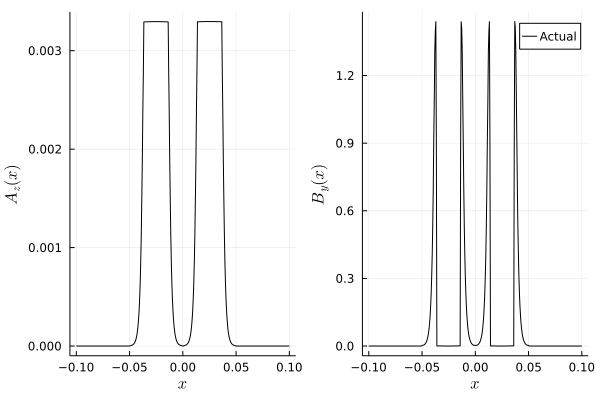

In [178]:
# Post-processing
ux    = zeros(Complex{Float64}, Na);
Jeddy = zeros(Complex{Float64}, Na);

Emat = 2 * [2, -4, 2] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] += [dux[1]/2; dux[2]; dux[3]/2];
    
    Jeddy[edges[i]] += 1im * omega * fsigma_elem[i] * [ul/2 um ur/2]';
end

# Plot
p1 = plot(X, norm.(u), xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(X, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, label = "Actual");
#p2 = plot!(xmid, norm.(diff(ulin) ./ diff(X)), color = :red, style = :dash, label = "No sat.")

plot(p1, p2)

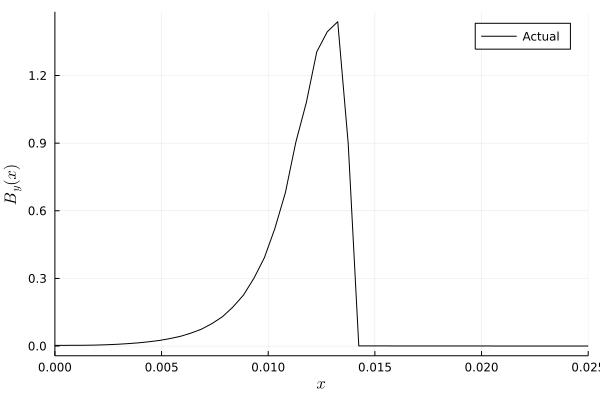

In [180]:
plot(X, norm.(ux), xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, label = "Actual")
xlims!((0, 0.025))